Для начала подключим библиотеки, которые нам понадобятся и загрузим данные.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.core.pylabtools import figsize
figsize(10, 10)
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Rain.csv', sep=',')


Mounted at /content/drive


Посмотрим несколько записей из набора данных.

In [ ]:
data.head(10)

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,13.6,19.2,8.0,4.2,0.4,56.0,20.0,17.0,88.0,94.0,1028.4,1025.4,8.0,8.0,16.0,16.0,1,1
1,1,24.3,32.3,0.0,5.2,5.2,46.0,11.0,9.0,61.0,96.0,1010.7,1008.5,6.0,7.0,27.9,24.6,0,1
2,2,22.9,34.8,0.0,9.6,5.3,56.0,19.0,13.0,27.0,25.0,1004.9,1003.4,7.0,7.0,30.6,33.5,0,1
3,3,17.9,19.4,0.0,2.2,3.1,48.0,26.0,17.0,87.0,82.0,1014.9,1013.5,8.0,7.0,19.0,17.9,0,1
4,4,15.7,23.4,0.0,7.8,9.6,35.0,15.0,15.0,55.0,64.0,1009.1,1008.8,8.0,7.0,20.4,21.3,0,1
5,5,21.2,29.8,3.6,6.6,5.4,54.0,26.0,35.0,71.0,52.0,1015.8,1013.1,5.0,7.0,25.5,27.5,1,1
6,6,13.2,19.1,0.0,1.6,1.2,59.0,13.0,22.0,75.0,71.0,1020.0,1015.7,6.0,7.0,14.7,18.0,0,1
7,7,7.4,14.9,0.0,1.6,6.0,44.0,17.0,19.0,77.0,63.0,1018.8,1013.8,1.0,7.0,9.1,12.5,0,1
8,8,19.2,29.8,0.0,5.2,9.9,52.0,9.0,24.0,61.0,57.0,1008.0,1004.9,1.0,1.0,27.7,28.4,0,1
9,9,8.5,15.6,0.0,2.2,7.6,65.0,28.0,33.0,67.0,44.0,1021.7,1018.3,1.0,7.0,12.0,14.8,0,1


Удалим ненужный столбец.

In [ ]:
data=data.drop(['Unnamed: 0'], axis='columns')

Выделим в нашей выборке целевую переменную, а также разделим ее на тренировочную и тестовую. Цель построения модели - классифицировать новые данные. По умолчанию,train_test_split откладывает 25% выборок в исходном наборе данных для тестирования.

In [ ]:
X = data[data.columns[:-1]]
y = data['RainTomorrow']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)


Посмотрим на распределения и возможные зависимости признаков.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


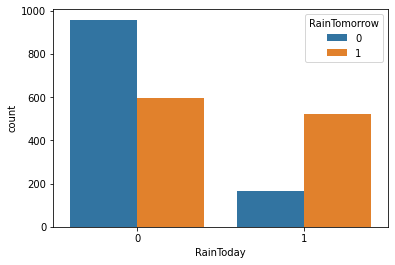

In [ ]:
sns.countplot(X_train['RainToday'], hue=y_train)

Будет ли дождь завтра (RainTomorrow) в зависимости от того, был ли он сегодня (RainToday). Если сегодня дождя не было, то, вероятно, его и завтра не будет. Если сегодня дождь был, то завтра практически точно будет дождь.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


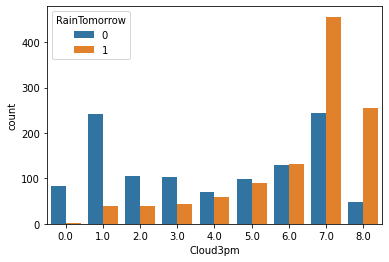

In [ ]:
sns.countplot(X_train['Cloud3pm'], hue=y_train)

Зависимость RainTomorrow от Cloud3pm (облачность в 3 часа дня). Чем выше облачность, тем более вероятен дождь завтра.

Построим корреляцию признаков между собой.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


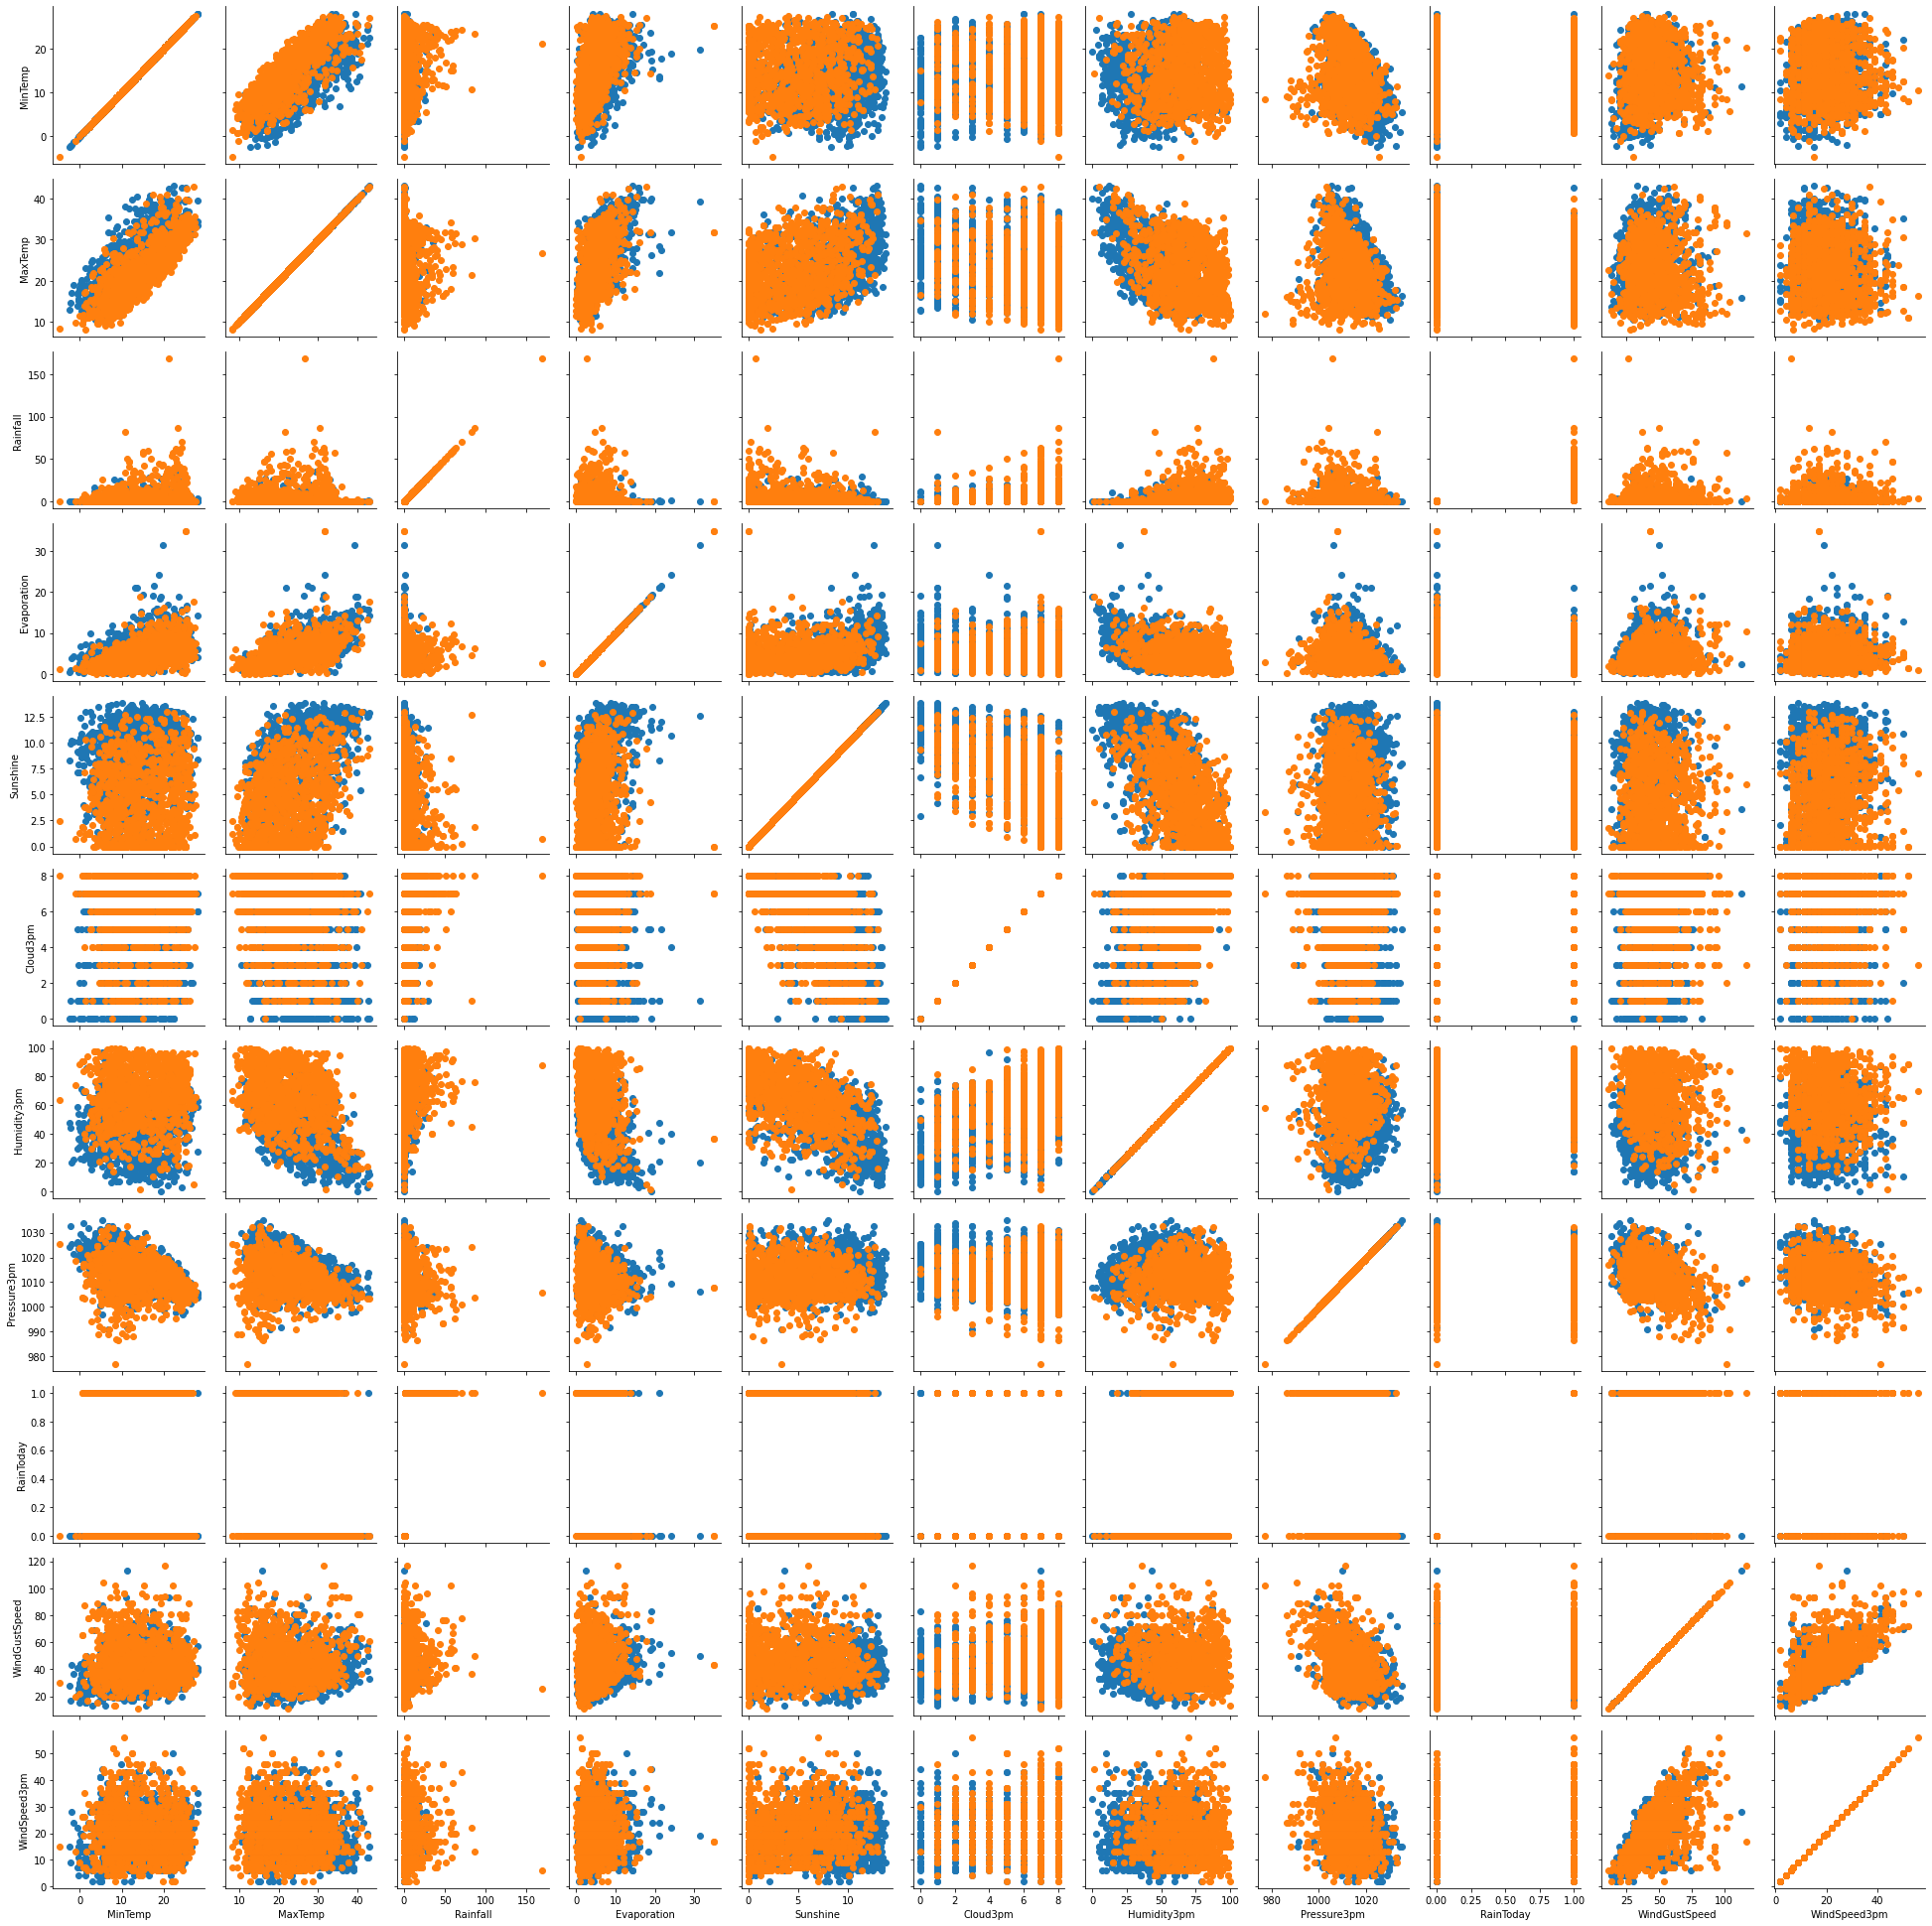

In [ ]:
df_for_pairgrid = X_train[['MinTemp', 'MaxTemp', 'Rainfall','Evaporation','Sunshine','Cloud3pm','Humidity3pm','Pressure3pm','RainToday','WindGustSpeed','WindSpeed3pm']]
df_for_pairgrid['RainTomorrow'] = y_train

sns.PairGrid(df_for_pairgrid, hue='RainTomorrow').map(plt.scatter)

Посмотрим выбросы и плотность распределения величины.

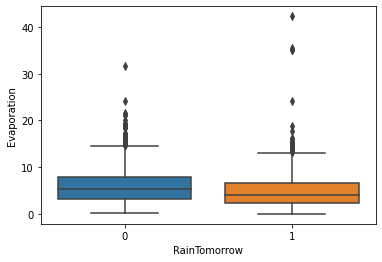

In [ ]:

Evaporation = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Rain.csv', sep=',')['Evaporation'].apply(lambda x: x if x >= 0 else x / 5000)
sns.boxplot(x=y, y=Evaporation)

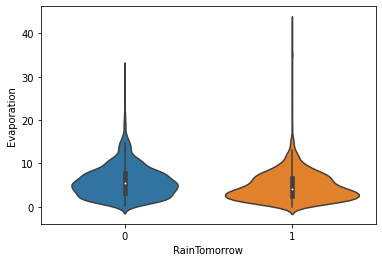

In [ ]:
sns.violinplot(x=y, y=Evaporation)

Произведем нормализацию признаков.

Качество алгоритма до нормализации: 0.7914438502673797
Качество алгоритма после нормализации: 0.7914438502673797


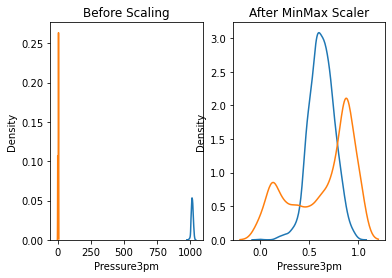

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

print("Качество алгоритма до нормализации:",
      KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train).score(X_test, y_test))
#обучаем нормализатор выборки значений на min/max
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train, ), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

print("Качество алгоритма после нормализации:",
      KNeighborsClassifier(n_neighbors=9).fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

# графики
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['Pressure3pm'], ax=ax1)
sns.kdeplot(X_train['Cloud3pm'], ax=ax1)
ax2.set_title('After MinMax Scaler')
sns.kdeplot(X_train_scaled['Pressure3pm'], ax=ax2)
sns.kdeplot(X_train_scaled['Cloud3pm'], ax=ax2)
plt.show()

В данном случае нормализация позволяет оценить вклад двух признаков (плотность и давление в 3 часа дня) в одинаковом масштабе, однако на качество алгоритма это не повлияло.

Произведем подбор алгоритма.

In [ ]:
#импортируем классификаторы
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
#цикл по каждому классификатору
for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    print(clf.__class__.__name__, clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.6978609625668449
SGDClassifier 0.803475935828877
SVC 0.8088235294117647
GaussianNB 0.7914438502673797
KNeighborsClassifier 0.7780748663101604


Наилучшее качество нам дает метод SVС (метод опорных векторов).

Посмотрим на распределение классов в тренировочной выборке.

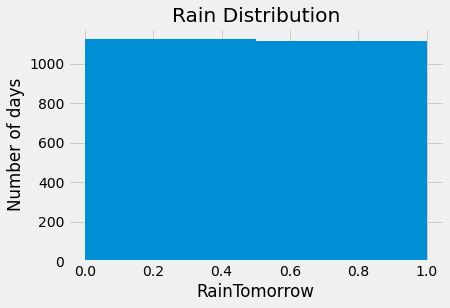

In [ ]:
plt.style.use('fivethirtyeight')
plt.hist(y_train, bins=2);
plt.xlabel('RainTomorrow'); plt.ylabel('Number of days');
plt.title('Rain Distribution');

Если нужна стратификация:

In [ ]:
#X_train_scaled.reset_index(inplace=True, drop=True)
#y_train.reset_index(drop=True, inplace=True)

In [ ]:
#RainYes = X_train_scaled[y_train == 1]
#X_train_strat = pd.concat([X_train_scaled, RainYes, RainYes,RainYes], ignore_index=True)
#y_train_strat = pd.concat([y_train, pd.Series(np.ones(X_train_strat.shape[0]-X_train_scaled.shape[0]))],
                          ignore_index=True)

In [ ]:
#for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    #print(clf.__class__.__name__, clf.fit(X_train_strat, y_train_strat).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.7889518413597734
SGDClassifier 0.8456090651558074
SVC 0.7974504249291785
GaussianNB 0.7974504249291785
KNeighborsClassifier 0.7365439093484419


Посмотрим различные метрики.

In [ ]:
a=clf.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc

print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))
print('F0.5:', fbeta_score(y_test, a, 0.5))
print('F2:', fbeta_score(y_test, a, 2))

Accuracy: 0.7780748663101604
Precision: 0.7851239669421488
Recall: 0.7640750670241286
ROC AUC: 0.7780375335120643
PRC AUC: 0.8334230463949034
F1: 0.7744565217391304
F0.5: 0.7808219178082193
F2: 0.7681940700808626


Выберем метрику Recall из логики задачи, т.е. задачи прогноза погоды. Если модель предсказывает, что дождь будет, а его не будет - это не так критично, как если бы было наоборот.

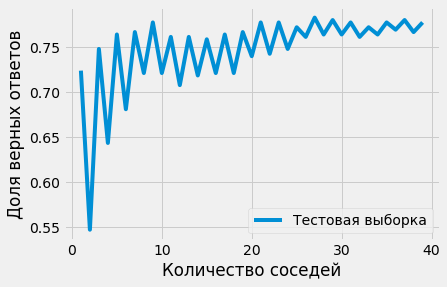

In [ ]:
test_scores = {}
for n in range(1, 40):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train_scaled, y_train)
    a=clf.predict(X_test_scaled)
    current_test_score = recall_score(y_test, a)
    test_scores[n] = current_test_score
plt.plot(list(test_scores.keys()), list(test_scores.values()), label='Тестовая выборка')
plt.xlabel('Количество соседей')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Количество соседей с метрикой recall - 27.

In [ ]:
clf = KNeighborsClassifier(n_neighbors=27)
clf.fit(X_train_scaled, y_train)
a=clf.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))
print('F0.5:', fbeta_score(y_test, a, 0.5))
print('F2:', fbeta_score(y_test, a, 2))

Accuracy: 0.7954545454545454
Precision: 0.8055555555555556
Recall: 0.7774798927613941
ROC AUC: 0.7954066130473637
PRC AUC: 0.8469990075809347
F1: 0.791268758526603
F0.5: 0.7997793712079425
F2: 0.782937365010799
